In [694]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2
from sklearn.covariance import MinCovDet
from scipy import linalg

In [695]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)
warnings.filterwarnings('ignore')

In [790]:
def plotCorrelation(df):
    """ Wrapper to plot correlation of 1 variable against many """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df = df.loc[df.index != df['feature1']]
    sns.heatmap(pd.DataFrame(df['R']), yticklabels=1, 
                cmap='bwr', vmin=-1, vmax=1, ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(df['p']), yticklabels=1, 
                cmap='viridis', vmin=0, vmax=1, ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    return fig, (ax1, ax2)

In [791]:
def pearsonr_pval(x,y):
    try:
        return pearsonr(x,y)[1]
    except ValueError:
        return np.nan

In [792]:
def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)

In [765]:
def mahalanobis(data):
    """ Compute Mahalanobis Distance between 
        each row of data with the data. """  
    x_minus_mu = data - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [819]:
def plotBivariateOutlier(x, y, data, threshold=0.01):
    """ Plot scatter with indexes of outliers labelled """
    sub = data[[x, y]]
    sub['mahalanobis'] = mahalanobis(sub)
    sub['outlier'] = subX['mahalanobis'] > chi2.ppf((1 - threshold), df=2)
    fig, ax = plt.subplots(1)
    sns.scatterplot(x=x, y=y, hue='outlier', data=sub, ax=ax)
    for outlier in subX[subX['outlier']].index:
        ax.text(subX.loc[outlier, 'SalePrice'], subX.loc[outlier, 'GrLivArea'], outlier)
    fig.tight_layout()
    return fig, ax

In [823]:
def plotDistribution(x):
    """ Wrapper to plot univariate distribution 
        and probability plot"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.distplot(x, ax=ax1)
    ax1.set_title(f'Skewness = {y.skew():.2f}; Kurtosis = {y.kurtosis():.2f}')
    stats.probplot(x, plot=ax2)
    ax2.set_title(f'Probability Plot: {ax1.get_xlabel()}')
    fig.tight_layout()
    return fig, (ax1, ax2)

In [824]:
trainPath = 'train.csv'
target = 'SalePrice'

In [825]:
X = pd.read_csv(trainPath, index_col='Id')

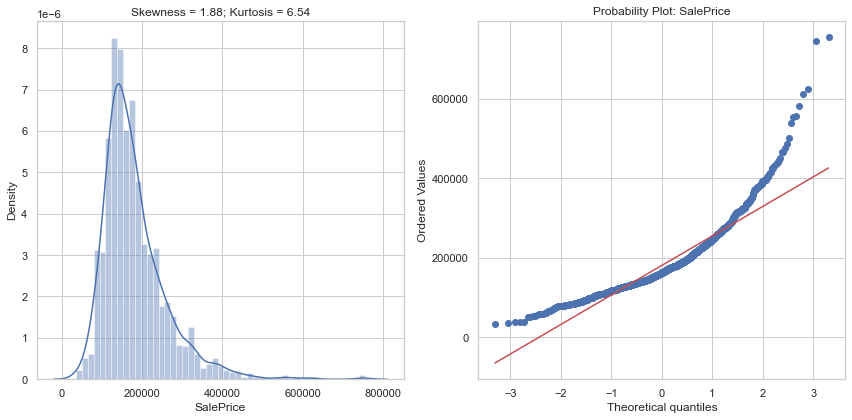

In [826]:
fig, (ax1, ax2) = plotDistribution(X[target])

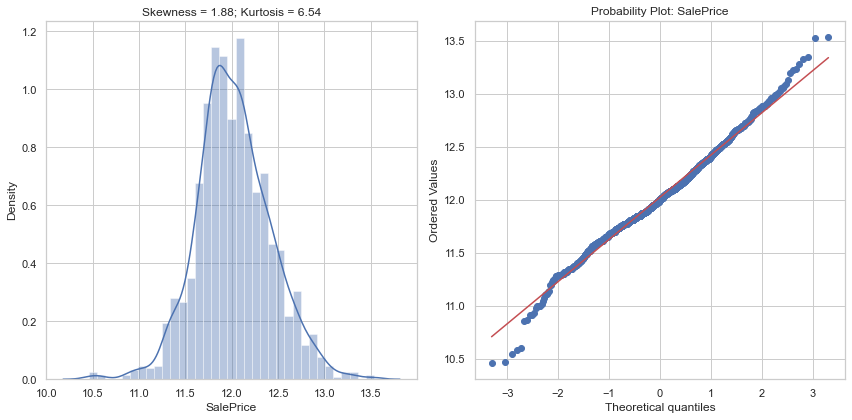

In [827]:
fig, (ax1, ax2) = plotDistribution(np.log(X[target]))

In [801]:
#y = np.log(y)

### Correlation analysis
- Correlate each numerical feature with the predictor.
- Save p-value, N and correlation coefficient for later.

In [802]:
featureCorr = []
for method in ['pearson', pearsonr_pval, countPair]:
    values = X.corr(method=method).stack()
    featureCorr.append(values)
featureCorr = (
    pd.concat(featureCorr, axis=1)
    .reset_index()
    .rename(columns={'level_0': 'feature1', 
                     'level_1': 'feature2', 
                     0: 'R', 1: 'p', 2: 'n'}))
featureCorr['significant'] = featureCorr['p'] < 0.05

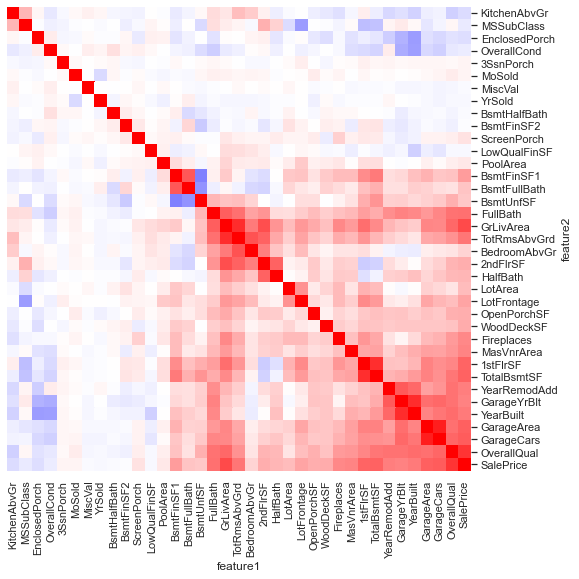

In [803]:
# Convert correlation coefficients to wide format and fill NA (diagonal)
wideCorr = featureCorr.pivot(columns='feature1', index='feature2', values='R')
ax = sns.clustermap(
    wideCorr,
    xticklabels=1, yticklabels=1, 
    row_cluster=True, col_cluster=True,
    cbar_pos=None, cmap='bwr', vmin=-1, vmax=1)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
plt.tight_layout()

In [804]:
targetCorr = (
    featureCorr.loc[featureCorr['feature1'] == target]
    .set_index('feature2'))
targetCorr = targetCorr.sort_values(by=['R'], ascending=False)

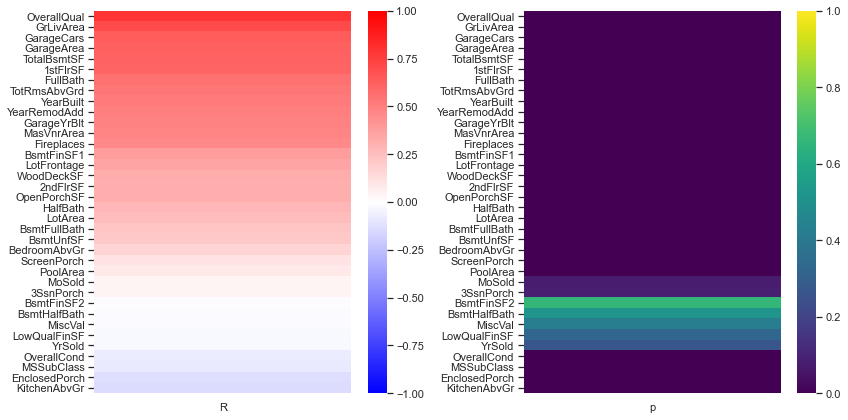

In [805]:
fig, (ax1, ax2) = plotCorrelation(targetCorr)

### Missing data assessment
- Compute NA frequency for each feature

In [806]:
nullOrd = X.isnull().sum().sort_values(ascending=False)
nullOrd = nullOrd[nullOrd > 0]
nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
nullOrd['PropNA'] = nullOrd['TotalNA'] / len(X)
nullOrd

,TotalNA,PropNA
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


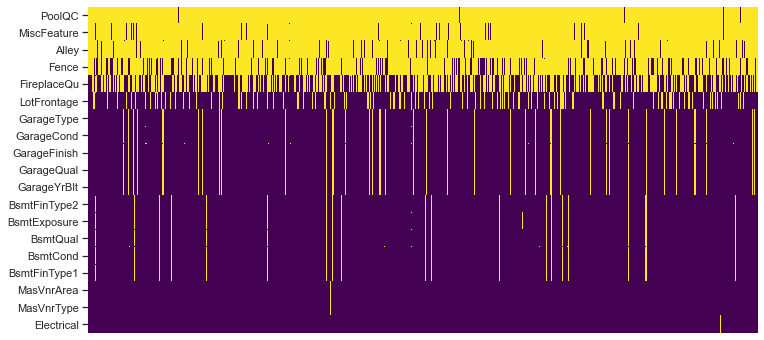

In [807]:
fix, ax = plt.subplots()
sns.heatmap(X[nullOrd.index].isnull().T, yticklabels=1, cmap='viridis', cbar=False, xticklabels=False, ax=ax)
ax.set_xlabel('')
ax.tick_params(left=True)
fig.tight_layout()

## Missing values

### High proportion NA features
- Remove all features with > 15% missing values.
- No strong relationship with SalePrice anyway.

In [808]:
manyNAfeatures = nullOrd[(nullOrd['PropNA'] > 0.15)].index
set(featureCorr['feature1']).intersection(set(manyNAfeatures))

{'LotFrontage'}

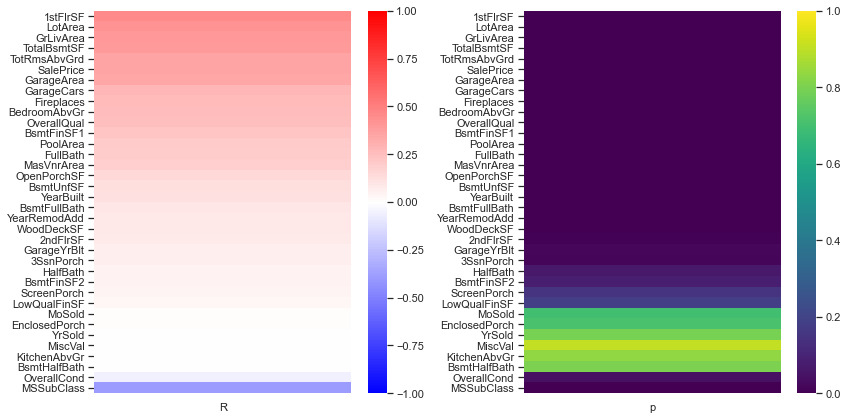

In [809]:
highNA = (
    featureCorr.loc[featureCorr['feature1'] == 'LotFrontage']
    .sort_values('R', ascending=False)
    .set_index('feature2'))
fig, (ax1, ax2) = plotCorrelation(highNA)

In [810]:
X = X.drop(manyNAfeatures, axis=1)

### Garage
- Missing values for all the garageX features appear to indicate presence / absence of garage.
- This is already represent in garage cars.
- Remove these features.

In [811]:
garageXfeatures = ['GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual']
X = X.drop(garageXfeatures, axis=1)

### Basement
- Same logic to missing basement X feature with many NAs.
- Remove these features.

In [812]:
basementXfeatures = ['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
X = X.drop(basementXfeatures, axis=1)
X['Basement'] = X['BsmtQual'].notna()

### MasVnrArea & MasVnrType
- Remove these features

In [813]:
X = X.drop(['MasVnrArea', 'MasVnrType'], axis=1)

### Electrical
- Only 1 missing value.
- Remove observation.

In [814]:
X = X[X['Electrical'].notna()]

### Save processed
- Remerge features and predictor.
- Ensure to filter predictor by remaining indexes in feature in case rows have been filtered.

In [815]:
pd.merge(X, y[X.index], left_index=True, right_index=True).to_csv('trainFilt.csv')

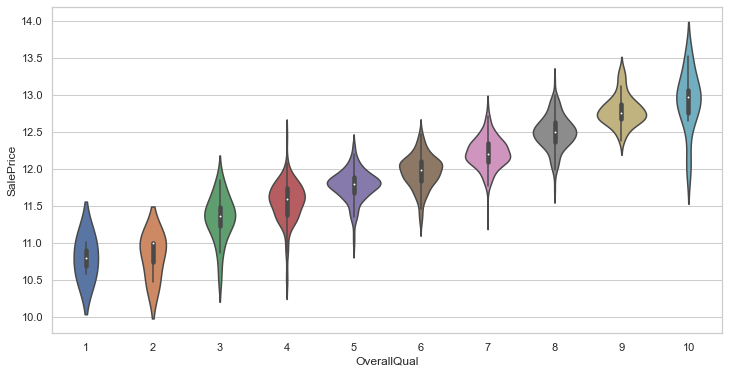

In [308]:
fix, ax = plt.subplots()
sns.violinplot(x=X['OverallQual'], y=y, ax=ax)
fig.tight_layout()

## Inspecting categoricals

In [264]:
catGroups = X.select_dtypes(exclude=['number'])
catDescribe = catGroups.describe().sort_values(by=['unique'], ascending=False, axis=1).T
catSmallest = catGroups.melt().groupby('variable').apply(lambda x: x.value_counts().min()).rename('smallestGroup')
catDescribe = pd.merge(catDescribe, catSmallest,
                       left_index=True, right_index=True)
catDescribe

,count,unique,top,freq,smallestGroup
Exterior2nd,1460,16,VinylSd,504,1
Exterior1st,1460,15,VinylSd,515,1
Neighborhood,1460,13,other,315,51
SaleType,1460,9,WD,1267,2
Condition1,1460,9,Norm,1260,2
Condition2,1460,8,Norm,1445,1
HouseStyle,1460,8,1Story,726,8
RoofMatl,1460,8,CompShg,1434,1
Functional,1460,7,Typ,1360,1
BsmtFinType2,1422,6,Unf,1256,14


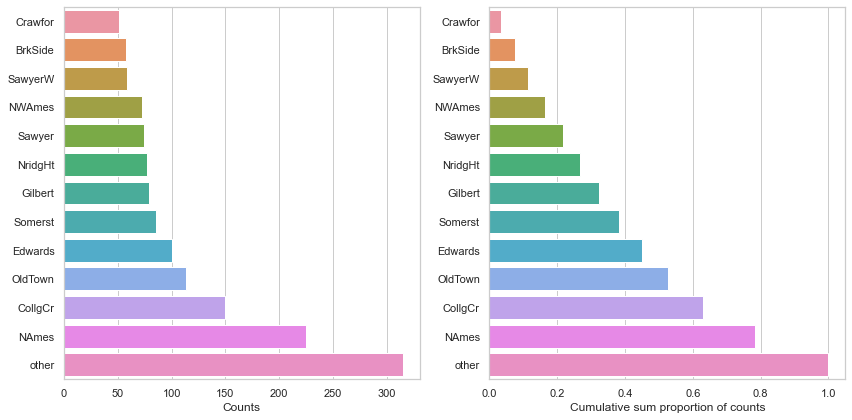

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2)
counts = X['Neighborhood'].value_counts().sort_values()
countsSum = X['Neighborhood'].value_counts(normalize=True).sort_values().cumsum()
sns.barplot(counts.values, counts.index, ax=ax1)
ax1.set_xlabel('Counts')
sns.barplot(countsSum.values, countsSum.index, ax=ax2)
ax2.set_xlabel('Cumulative sum proportion of counts')
fig.tight_layout()

In [242]:
X['Neighborhood'] = X['Neighborhood'].replace(countsSum[countsSum < 0.25].index, 'other')

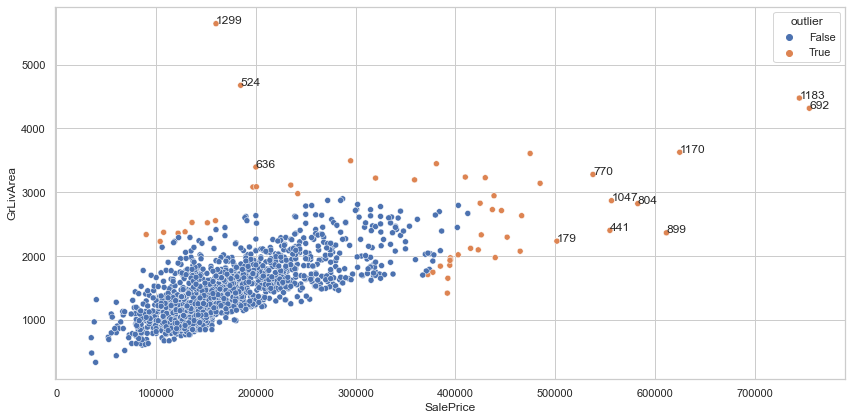

In [820]:
fig, ax = plotBivariateOutlier(x='SalePrice', y='GrLivArea', data=X)

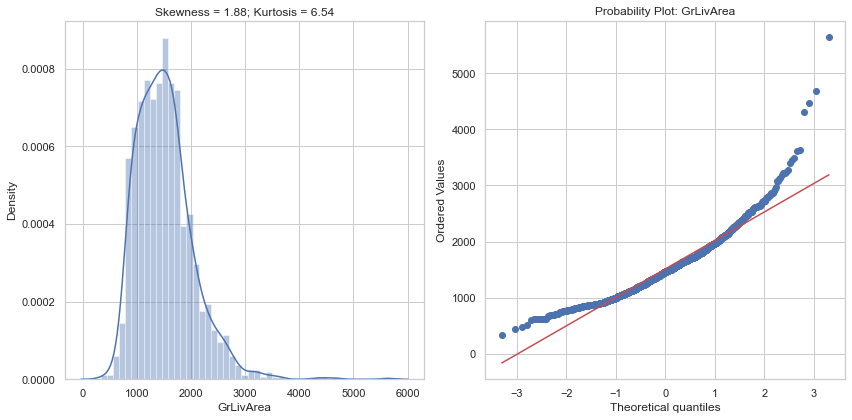

In [830]:
fig, ax = plotDistribution(X['GrLivArea'])

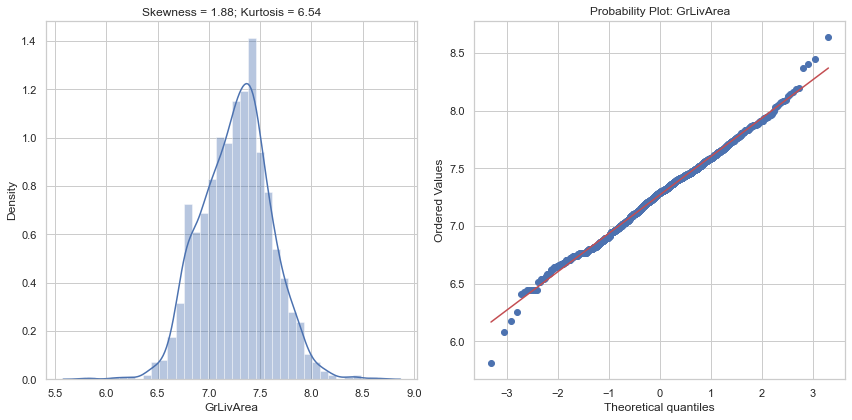

In [831]:
fig, ax = plotDistribution(np.log(X['GrLivArea']))